In [11]:
import os
import rasterio
import json
import pycrs
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 


from calendar import monthrange
from datetime import date
from rasterio.mask import mask

In [ ]:
""" Code for sampling SSEBOP aet using shapefile.
    Files need to be replaced accordingly"""

In [5]:
geodf = gpd.read_file("cuencas.shp")
cuencas = geodf['NOM_CUEN'].unique()

In [9]:
files = [n for n in os.listdir() if (n.endswith('.tif')) & (n.startswith('m'))]

In [7]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


def get_basinAET(gdf, basin, image):
    data = rasterio.open(image)
    date_img = date(int(image[1:5]), int(image[5:7]), 1)
    days = monthrange(int(image[1:5]), int(image[5:7]))[1]
    coords = getFeatures(gdf[gdf['NOM_CUEN'] == basin])
    out_img, out_transform = mask(data, shapes=coords, crop=True)
    out_img = out_img.astype(float)
    out_img[out_img < 0] = np.nan
    mean_AET = np.nanmean(out_img)/days
    return date_img, mean_AET


def save_cropped(gdf, basin, image):
    data = rasterio.open(image)
    coords = getFeatures(gdf[gdf['NOM_CUEN'] == basin])
    out_img, out_transform = mask(data, shapes=coords, crop=True)
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
    with rasterio.open('{}_{}.tif'.format(basin, image[1:7]), "w", **out_meta) as dest:
        dest.write(out_img)

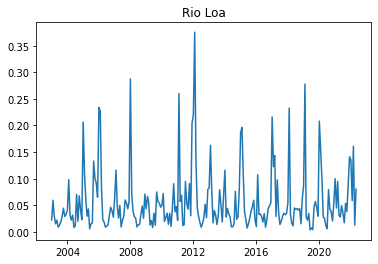

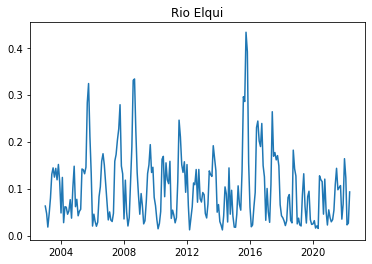

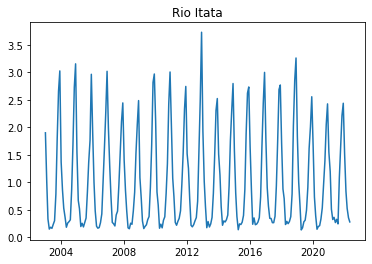

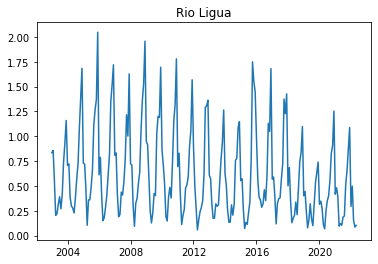

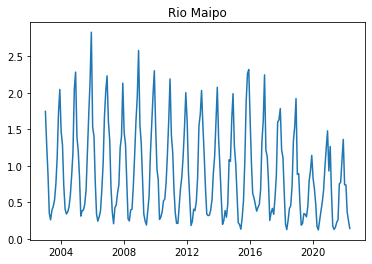

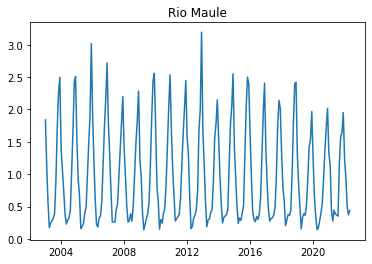

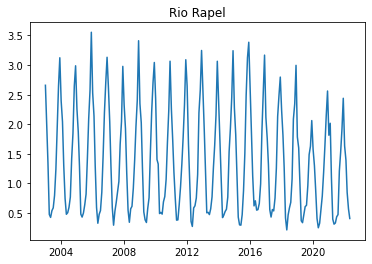

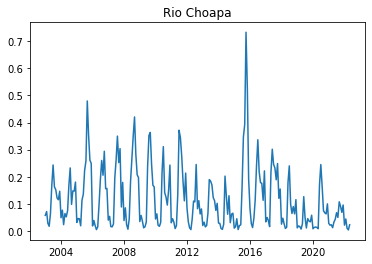

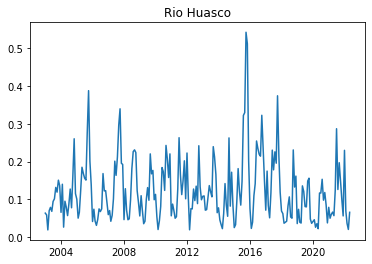

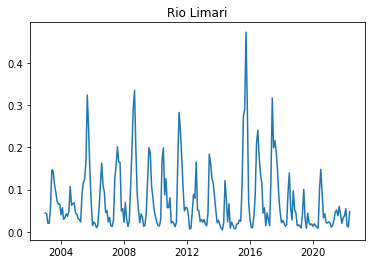

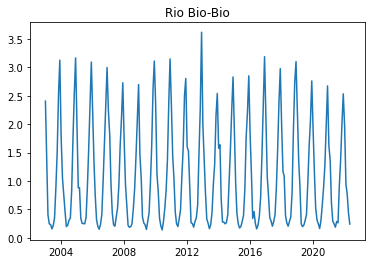

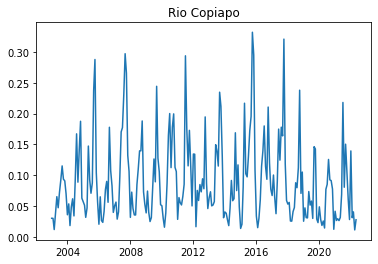

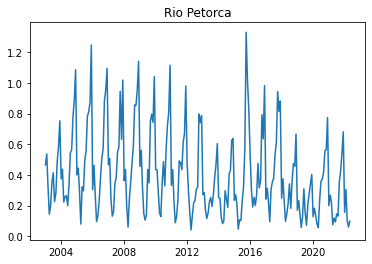

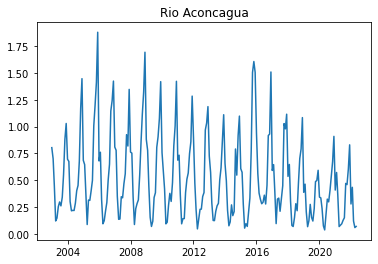

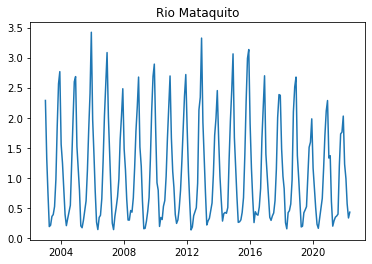

In [14]:
dfs = []
for m in cuencas:
    dates, aets = [], []
    for n in files[:-1]:
        date_img, aet = get_basinAET(geodf, m, n)
        dates.append(date_img), aets.append(aet)
    df = pd.DataFrame(index=dates, data={'aet_{}'.format(m):aets})
    df = df.sort_index()
    plt.plot(dates, aets)
    plt.title(m)
    plt.show()
    dfs.append(df)

In [ ]:
dfs = pd.concat(dfs, axis=1)
dfs.to_csv('ssebop_aet.csv')